# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples

In [1]:
TGT='Reply'
PRFX='Reply0405_4'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(1e5)#int(1e5)
trnsz = int(1e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.set_verbosity(optuna.logging.ERROR)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(100000, 24)


retwt          0.11211
reply          0.02754
like           0.43929
retwt_cmmnt    0.00801
dtype: float64

CPU times: user 736 ms, sys: 76 ms, total: 812 ms
Wall time: 812 ms


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(370000, 24)


retwt          0.112570
reply          0.028143
like           0.438841
retwt_cmmnt    0.007565
dtype: float64

CPU times: user 2.83 s, sys: 276 ms, total: 3.11 s
Wall time: 3.11 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(100000, 24) 0.10413
370000 10413 100000 10413


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
5,101\t1434\t107854\t18260\t31904\t111431\t74759...,NaN,0EB15633A8CC0A6E3917C272F43E6DF3,NaN,NaN,NaN,TopLevel,022EC308651FACB02794A8147AEE1B78,1581218899,A7E00C86B4E3709D589754A51042A360,1198215,662,True,1246548812,016212C070A76EAB37E8ED93CA509BA9,0,42,False,1578271262,False,False,True,False,False
51,101\t10473\t10116\t10132\t12603\t97953\t25307\...,NaN,7C71C144E7B9F2D87F1F4DDB40AB1C49,NaN,NaN,NaN,TopLevel,2996EB2FE8162C076D070A4C8D6532CD,1581203618,B0CBECD53C3B945C875C55DDFF56D13F,1424,854,False,1394906655,01625341E5A48963E5AA7DFFDC4436D4,643,327,False,1372760933,True,False,True,False,False
63,101\t56898\t137\t24362\t131\t100\t196\t36351\t...,NaN,ADCF033A7C7087C1506E2BC3E2D8F092,NaN,NaN,NaN,Retweet,717293301FE296B0B61950D041485825,1581258397,ECD90FC37F0A7C15C82834FDDEEDC21A,1753,811,False,1568347799,01625CCEC5A4C322FC247DB9E223CC08,147,1355,False,1355850070,False,False,True,False,False
75,101\t12441\t105702\t793\t61783\t34022\t60578\t...,NaN,7EB0824DDA3D28844CC0FF65B7C4AA08,NaN,NaN,NaN,TopLevel,167115458A0DBDFF7E9C0C53A83BAC9B,1581271814,D905F31F909CC63C2BBEB7F6B43487FE,175998,116,False,1466830888,01626B64A2570C2807AB97716262FBA9,90,139,False,1364278366,False,False,True,False,False
83,101\t69532\t10107\t12372\t10160\t19048\t136\t1...,NaN,0A95516F028EBFF6B551DB32C4B2D1B5,Video,NaN,NaN,TopLevel,ECED8A16BE2A5E8871FD55F4842F16B1,1581214010,88E80BAB56E6F59E4EF012A8B12D3BAE,8825,8024,False,1557262802,0162759D8908AA8C849F06086A023D85,26265,24215,False,1557422269,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    
    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-06 15:25:53 start
2020-04-06 15:25:55 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 15:25:57 freq of tags
2020-04-06 15:25:58 done
CPU times: user 4.45 s, sys: 228 ms, total: 4.68 s
Wall time: 4.63 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-06 15:25:58 start
2020-04-06 15:25:59 freq of columns using CountEncoder
2020-04-06 15:26:01 freq of tags
2020-04-06 15:26:02 done
CPU times: user 3.94 s, sys: 52.5 ms, total: 3.99 s
Wall time: 3.97 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'len_toks',
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 'has_hshtgs',
       'n_hshtgs', 'has_media', 'n_media', 'has_domns', 'n_domns', 'dayofweek',
       'hour', 'tmdlta_u2u1', 'tmdlta_twtu1', 'tmdlta_twtu2', 'twt_age',
       'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age', 'u1_fllwng_cnt_by_age',
       'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp', 'frq_lang', 'frq_u1id',
       'frq_u1_fllwing_cnt', 'frq_u1_vrfed', 'frq_u2id', 'frq_u2_fllwer_cnt',
       'frq_u2_vrfed', 'frq_u1_fllw_u2', 'frq_n_media_Photo',
       'frq_n_media_Video', 'frq_n_media_GIF', 'frq_has_hshtgs',
       'frq_n_hshtgs', 'frq_has_media', 'frq_n_media', 'frq_has_domns',
       'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2', 'frq_langhour',
       'sumfrq_hshtgs', 'maxfrq_hshtgs', 'su

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 4.75 s, sys: 0 ns, total: 4.75 s
Wall time: 4.74 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

In [16]:
dftr.dtypes

twttyp                   category
lang                     category
u1_fllwer_cnt               int64
u1_fllwing_cnt              int64
u1_vrfed                     bool
u2_fllwer_cnt               int64
u2_fllwng_cnt               int64
u2_vrfed                     bool
u1_fllw_u2                   bool
retwt                        bool
reply                        bool
like                         bool
retwt_cmmnt                  bool
len_toks                    int64
n_media_Photo               int64
n_media_Video               int64
n_media_GIF                 int64
has_hshtgs                   bool
n_hshtgs                    int64
has_media                    bool
n_media                     int64
has_domns                    bool
n_domns                     int64
dayofweek                   int64
hour                        int64
tmdlta_u2u1                 int64
tmdlta_twtu1                int64
tmdlta_twtu2                int64
twt_age                     int64
u1_age        

# model

In [17]:
cols_feat=['twttyp',
#  'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
#  'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
#  'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
#  'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
#  'frq_u1u2',
#  'frq_langhour',
#  'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
#  'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
 'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]

In [18]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [19]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,
    
}
results['params'] = params

In [20]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.256675	vl's binary_logloss: 0.29019
Early stopping, best iteration is:
[64]	tr's binary_logloss: 0.265721	vl's binary_logloss: 0.289863


tune_feature_fraction, val_score: 0.289863:  14%|#4        | 1/7 [00:02<00:11,  1.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.255334	vl's binary_logloss: 0.290938
Early stopping, best iteration is:
[69]	tr's binary_logloss: 0.262439	vl's binary_logloss: 0.29029


tune_feature_fraction, val_score: 0.289863:  29%|##8       | 2/7 [00:03<00:09,  1.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253933	vl's binary_logloss: 0.290968
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.262686	vl's binary_logloss: 0.289867


tune_feature_fraction, val_score: 0.289863:  43%|####2     | 3/7 [00:05<00:06,  1.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251212	vl's binary_logloss: 0.291835
Early stopping, best iteration is:
[37]	tr's binary_logloss: 0.27081	vl's binary_logloss: 0.29073


tune_feature_fraction, val_score: 0.289863:  57%|#####7    | 4/7 [00:06<00:05,  1.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.24833	vl's binary_logloss: 0.292135
Early stopping, best iteration is:
[37]	tr's binary_logloss: 0.269617	vl's binary_logloss: 0.29124


tune_feature_fraction, val_score: 0.289863:  71%|#######1  | 5/7 [00:08<00:03,  1.64s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.247876	vl's binary_logloss: 0.293015
Early stopping, best iteration is:
[37]	tr's binary_logloss: 0.269024	vl's binary_logloss: 0.291448


tune_feature_fraction, val_score: 0.289863:  86%|########5 | 6/7 [00:09<00:01,  1.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245923	vl's binary_logloss: 0.29368
Early stopping, best iteration is:
[40]	tr's binary_logloss: 0.266772	vl's binary_logloss: 0.292066


tune_num_leaves, val_score: 0.289863:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2018	vl's binary_logloss: 0.292801
Early stopping, best iteration is:
[38]	tr's binary_logloss: 0.246914	vl's binary_logloss: 0.290862


tune_num_leaves, val_score: 0.289863:   5%|5         | 1/20 [00:02<00:47,  2.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.28421	vl's binary_logloss: 0.29131
[200]	tr's binary_logloss: 0.279928	vl's binary_logloss: 0.290323
[300]	tr's binary_logloss: 0.276643	vl's binary_logloss: 0.289956
[400]	tr's binary_logloss: 0.27386	vl's binary_logloss: 0.289907
[500]	tr's binary_logloss: 0.270873	vl's binary_logloss: 0.289951
Early stopping, best iteration is:
[419]	tr's binary_logloss: 0.273313	vl's binary_logloss: 0.289755


tune_num_leaves, val_score: 0.289755:  10%|#         | 2/20 [00:05<00:46,  2.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.202892	vl's binary_logloss: 0.292037
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.230193	vl's binary_logloss: 0.290568


tune_num_leaves, val_score: 0.289755:  15%|#5        | 3/20 [00:08<00:44,  2.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.175041	vl's binary_logloss: 0.293905
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.209508	vl's binary_logloss: 0.291813


tune_num_leaves, val_score: 0.289755:  20%|##        | 4/20 [00:12<00:48,  3.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271125	vl's binary_logloss: 0.289711
[200]	tr's binary_logloss: 0.260377	vl's binary_logloss: 0.289963
Early stopping, best iteration is:
[107]	tr's binary_logloss: 0.27031	vl's binary_logloss: 0.289663


tune_num_leaves, val_score: 0.289663:  25%|##5       | 5/20 [00:13<00:38,  2.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.182272	vl's binary_logloss: 0.293372
Early stopping, best iteration is:
[38]	tr's binary_logloss: 0.235719	vl's binary_logloss: 0.291509


tune_num_leaves, val_score: 0.289663:  30%|###       | 6/20 [00:16<00:38,  2.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26132	vl's binary_logloss: 0.290198
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.268943	vl's binary_logloss: 0.289904


tune_num_leaves, val_score: 0.289663:  35%|###5      | 7/20 [00:18<00:30,  2.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.238425	vl's binary_logloss: 0.291354
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.251497	vl's binary_logloss: 0.290095


tune_num_leaves, val_score: 0.289663:  40%|####      | 8/20 [00:20<00:28,  2.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.16923	vl's binary_logloss: 0.293535
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.204472	vl's binary_logloss: 0.291104


tune_num_leaves, val_score: 0.289663:  45%|####5     | 9/20 [00:25<00:33,  3.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.277837	vl's binary_logloss: 0.29057
[200]	tr's binary_logloss: 0.271121	vl's binary_logloss: 0.290556
Early stopping, best iteration is:
[148]	tr's binary_logloss: 0.274383	vl's binary_logloss: 0.290307


tune_num_leaves, val_score: 0.289663:  50%|#####     | 10/20 [00:26<00:26,  2.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.152931	vl's binary_logloss: 0.295698
Early stopping, best iteration is:
[43]	tr's binary_logloss: 0.210565	vl's binary_logloss: 0.291218


tune_num_leaves, val_score: 0.289663:  55%|#####5    | 11/20 [00:31<00:28,  3.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.230827	vl's binary_logloss: 0.291345
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.245636	vl's binary_logloss: 0.290548


tune_num_leaves, val_score: 0.289663:  60%|######    | 12/20 [00:33<00:22,  2.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.286522	vl's binary_logloss: 0.292514
[200]	tr's binary_logloss: 0.282916	vl's binary_logloss: 0.291181
[300]	tr's binary_logloss: 0.280143	vl's binary_logloss: 0.290707
[400]	tr's binary_logloss: 0.277835	vl's binary_logloss: 0.290197
[500]	tr's binary_logloss: 0.27588	vl's binary_logloss: 0.290296
Early stopping, best iteration is:
[418]	tr's binary_logloss: 0.277497	vl's binary_logloss: 0.290142


tune_num_leaves, val_score: 0.289663:  65%|######5   | 13/20 [00:35<00:18,  2.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.232634	vl's binary_logloss: 0.290841
Early stopping, best iteration is:
[69]	tr's binary_logloss: 0.245803	vl's binary_logloss: 0.289729


tune_num_leaves, val_score: 0.289663:  70%|#######   | 14/20 [00:37<00:15,  2.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.227705	vl's binary_logloss: 0.291434
Early stopping, best iteration is:
[44]	tr's binary_logloss: 0.256165	vl's binary_logloss: 0.290618


tune_num_leaves, val_score: 0.289663:  75%|#######5  | 15/20 [00:39<00:11,  2.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.242891	vl's binary_logloss: 0.290538
Early stopping, best iteration is:
[69]	tr's binary_logloss: 0.253526	vl's binary_logloss: 0.289909


tune_num_leaves, val_score: 0.289663:  80%|########  | 16/20 [00:41<00:08,  2.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.218947	vl's binary_logloss: 0.291354
Early stopping, best iteration is:
[58]	tr's binary_logloss: 0.241593	vl's binary_logloss: 0.290107


tune_num_leaves, val_score: 0.289663:  85%|########5 | 17/20 [00:44<00:06,  2.26s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251312	vl's binary_logloss: 0.290475
Early stopping, best iteration is:
[64]	tr's binary_logloss: 0.261922	vl's binary_logloss: 0.289924


tune_num_leaves, val_score: 0.289663:  90%|######### | 18/20 [00:45<00:04,  2.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.208669	vl's binary_logloss: 0.292089
Early stopping, best iteration is:
[69]	tr's binary_logloss: 0.227021	vl's binary_logloss: 0.290274


tune_num_leaves, val_score: 0.289663:  95%|#########5| 19/20 [00:48<00:02,  2.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259495	vl's binary_logloss: 0.289974
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.267149	vl's binary_logloss: 0.289702


tune_num_leaves, val_score: 0.289663: 100%|##########| 20/20 [00:49<00:00,  2.50s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.289663:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271191	vl's binary_logloss: 0.290551
[200]	tr's binary_logloss: 0.261202	vl's binary_logloss: 0.29059
Early stopping, best iteration is:
[168]	tr's binary_logloss: 0.264019	vl's binary_logloss: 0.290462


tune_bagging_fraction_and_bagging_freq, val_score: 0.289663:  10%|#         | 1/10 [00:02<00:19,  2.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274963	vl's binary_logloss: 0.291008
[200]	tr's binary_logloss: 0.264695	vl's binary_logloss: 0.291302
Early stopping, best iteration is:
[141]	tr's binary_logloss: 0.270251	vl's binary_logloss: 0.290259


tune_bagging_fraction_and_bagging_freq, val_score: 0.289663:  20%|##        | 2/10 [00:03<00:16,  2.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275007	vl's binary_logloss: 0.291599
Early stopping, best iteration is:
[68]	tr's binary_logloss: 0.278854	vl's binary_logloss: 0.29128


tune_bagging_fraction_and_bagging_freq, val_score: 0.289663:  30%|###       | 3/10 [00:05<00:12,  1.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.27329	vl's binary_logloss: 0.291037
[200]	tr's binary_logloss: 0.262729	vl's binary_logloss: 0.290991
Early stopping, best iteration is:
[175]	tr's binary_logloss: 0.265195	vl's binary_logloss: 0.290556


tune_bagging_fraction_and_bagging_freq, val_score: 0.289663:  40%|####      | 4/10 [00:07<00:11,  1.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274858	vl's binary_logloss: 0.290063
Early stopping, best iteration is:
[66]	tr's binary_logloss: 0.279014	vl's binary_logloss: 0.28973


tune_bagging_fraction_and_bagging_freq, val_score: 0.289663:  50%|#####     | 5/10 [00:08<00:08,  1.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273363	vl's binary_logloss: 0.289496
[200]	tr's binary_logloss: 0.263122	vl's binary_logloss: 0.289807
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.269351	vl's binary_logloss: 0.289286


tune_bagging_fraction_and_bagging_freq, val_score: 0.289286:  60%|######    | 6/10 [00:10<00:06,  1.75s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273639	vl's binary_logloss: 0.290267
[200]	tr's binary_logloss: 0.263328	vl's binary_logloss: 0.290102
Early stopping, best iteration is:
[175]	tr's binary_logloss: 0.26577	vl's binary_logloss: 0.28962


tune_bagging_fraction_and_bagging_freq, val_score: 0.289286:  70%|#######   | 7/10 [00:12<00:05,  1.84s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272221	vl's binary_logloss: 0.290571
[200]	tr's binary_logloss: 0.261577	vl's binary_logloss: 0.290519
Early stopping, best iteration is:
[194]	tr's binary_logloss: 0.262207	vl's binary_logloss: 0.290378


tune_bagging_fraction_and_bagging_freq, val_score: 0.289286:  80%|########  | 8/10 [00:14<00:03,  1.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271468	vl's binary_logloss: 0.289808
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.271633	vl's binary_logloss: 0.289774


tune_bagging_fraction_and_bagging_freq, val_score: 0.289286:  90%|######### | 9/10 [00:16<00:01,  1.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275314	vl's binary_logloss: 0.29108
[200]	tr's binary_logloss: 0.265011	vl's binary_logloss: 0.291578
Early stopping, best iteration is:
[150]	tr's binary_logloss: 0.269824	vl's binary_logloss: 0.290671


tune_bagging_fraction_and_bagging_freq, val_score: 0.289286: 100%|##########| 10/10 [00:18<00:00,  1.81s/it]
tune_feature_fraction, val_score: 0.289286:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273363	vl's binary_logloss: 0.289496
[200]	tr's binary_logloss: 0.263122	vl's binary_logloss: 0.289807
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.269351	vl's binary_logloss: 0.289286


tune_feature_fraction, val_score: 0.289286:  33%|###3      | 1/3 [00:01<00:03,  1.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272371	vl's binary_logloss: 0.289944
[200]	tr's binary_logloss: 0.261949	vl's binary_logloss: 0.28984
Early stopping, best iteration is:
[166]	tr's binary_logloss: 0.265337	vl's binary_logloss: 0.289441


tune_feature_fraction, val_score: 0.289286:  67%|######6   | 2/3 [00:04<00:01,  1.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271858	vl's binary_logloss: 0.290054
Early stopping, best iteration is:
[70]	tr's binary_logloss: 0.275883	vl's binary_logloss: 0.289699


tune_feature_fraction, val_score: 0.289286: 100%|##########| 3/3 [00:05<00:00,  1.87s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.289286:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273351	vl's binary_logloss: 0.289685
Early stopping, best iteration is:
[89]	tr's binary_logloss: 0.274749	vl's binary_logloss: 0.289622


tune_lambda_l1_and_lambda_l2, val_score: 0.289286:   5%|5         | 1/20 [00:01<00:28,  1.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273363	vl's binary_logloss: 0.289496
[200]	tr's binary_logloss: 0.263122	vl's binary_logloss: 0.289807
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.269351	vl's binary_logloss: 0.289286


tune_lambda_l1_and_lambda_l2, val_score: 0.289286:  10%|#         | 2/20 [00:03<00:28,  1.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273363	vl's binary_logloss: 0.289496
[200]	tr's binary_logloss: 0.263122	vl's binary_logloss: 0.289807
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.269351	vl's binary_logloss: 0.289286


tune_lambda_l1_and_lambda_l2, val_score: 0.289286:  15%|#5        | 3/20 [00:05<00:28,  1.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273363	vl's binary_logloss: 0.289496
[200]	tr's binary_logloss: 0.263122	vl's binary_logloss: 0.289807
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.269351	vl's binary_logloss: 0.289286


tune_lambda_l1_and_lambda_l2, val_score: 0.289286:  20%|##        | 4/20 [00:07<00:28,  1.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2734	vl's binary_logloss: 0.289299
Early stopping, best iteration is:
[96]	tr's binary_logloss: 0.273867	vl's binary_logloss: 0.289194


tune_lambda_l1_and_lambda_l2, val_score: 0.289194:  25%|##5       | 5/20 [00:08<00:25,  1.73s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273363	vl's binary_logloss: 0.289496
[200]	tr's binary_logloss: 0.263122	vl's binary_logloss: 0.289807
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.269351	vl's binary_logloss: 0.289286


tune_lambda_l1_and_lambda_l2, val_score: 0.289194:  30%|###       | 6/20 [00:10<00:24,  1.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273593	vl's binary_logloss: 0.290019
[200]	tr's binary_logloss: 0.263316	vl's binary_logloss: 0.28991
Early stopping, best iteration is:
[134]	tr's binary_logloss: 0.269875	vl's binary_logloss: 0.289707


tune_lambda_l1_and_lambda_l2, val_score: 0.289194:  35%|###5      | 7/20 [00:12<00:23,  1.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273226	vl's binary_logloss: 0.289746
Early stopping, best iteration is:
[70]	tr's binary_logloss: 0.277182	vl's binary_logloss: 0.289603


tune_lambda_l1_and_lambda_l2, val_score: 0.289194:  40%|####      | 8/20 [00:14<00:20,  1.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273877	vl's binary_logloss: 0.289328
[200]	tr's binary_logloss: 0.264313	vl's binary_logloss: 0.289439
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.267946	vl's binary_logloss: 0.288998


tune_lambda_l1_and_lambda_l2, val_score: 0.288998:  45%|####5     | 9/20 [00:16<00:19,  1.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273326	vl's binary_logloss: 0.289556
[200]	tr's binary_logloss: 0.262683	vl's binary_logloss: 0.289997
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.269183	vl's binary_logloss: 0.28945


tune_lambda_l1_and_lambda_l2, val_score: 0.288998:  50%|#####     | 10/20 [00:17<00:18,  1.82s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.276714	vl's binary_logloss: 0.289954
[200]	tr's binary_logloss: 0.269746	vl's binary_logloss: 0.289339
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.273815	vl's binary_logloss: 0.289183


tune_lambda_l1_and_lambda_l2, val_score: 0.288998:  55%|#####5    | 11/20 [00:20<00:17,  1.91s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.276768	vl's binary_logloss: 0.289755
[200]	tr's binary_logloss: 0.269917	vl's binary_logloss: 0.289236
Early stopping, best iteration is:
[178]	tr's binary_logloss: 0.271235	vl's binary_logloss: 0.289066


tune_lambda_l1_and_lambda_l2, val_score: 0.288998:  60%|######    | 12/20 [00:22<00:16,  2.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.276913	vl's binary_logloss: 0.290153
[200]	tr's binary_logloss: 0.270309	vl's binary_logloss: 0.289955
Early stopping, best iteration is:
[139]	tr's binary_logloss: 0.273955	vl's binary_logloss: 0.289799


tune_lambda_l1_and_lambda_l2, val_score: 0.288998:  65%|######5   | 13/20 [00:24<00:14,  2.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273584	vl's binary_logloss: 0.289562
Early stopping, best iteration is:
[83]	tr's binary_logloss: 0.275616	vl's binary_logloss: 0.289413


tune_lambda_l1_and_lambda_l2, val_score: 0.288998:  70%|#######   | 14/20 [00:26<00:11,  1.96s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273967	vl's binary_logloss: 0.289653
[200]	tr's binary_logloss: 0.264639	vl's binary_logloss: 0.289174
Early stopping, best iteration is:
[166]	tr's binary_logloss: 0.267575	vl's binary_logloss: 0.288908


tune_lambda_l1_and_lambda_l2, val_score: 0.288908:  75%|#######5  | 15/20 [00:28<00:10,  2.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273455	vl's binary_logloss: 0.289646
[200]	tr's binary_logloss: 0.263448	vl's binary_logloss: 0.28947
Early stopping, best iteration is:
[181]	tr's binary_logloss: 0.265178	vl's binary_logloss: 0.289204


tune_lambda_l1_and_lambda_l2, val_score: 0.288908:  80%|########  | 16/20 [00:30<00:08,  2.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273367	vl's binary_logloss: 0.290071
Early stopping, best iteration is:
[70]	tr's binary_logloss: 0.27728	vl's binary_logloss: 0.289718


tune_lambda_l1_and_lambda_l2, val_score: 0.288908:  85%|########5 | 17/20 [00:32<00:05,  1.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274079	vl's binary_logloss: 0.289706
[200]	tr's binary_logloss: 0.264504	vl's binary_logloss: 0.289262
Early stopping, best iteration is:
[167]	tr's binary_logloss: 0.267475	vl's binary_logloss: 0.288938


tune_lambda_l1_and_lambda_l2, val_score: 0.288908:  90%|######### | 18/20 [00:34<00:03,  1.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274193	vl's binary_logloss: 0.289887
[200]	tr's binary_logloss: 0.264625	vl's binary_logloss: 0.289319
Early stopping, best iteration is:
[192]	tr's binary_logloss: 0.265281	vl's binary_logloss: 0.289181


tune_lambda_l1_and_lambda_l2, val_score: 0.288908:  95%|#########5| 19/20 [00:36<00:02,  2.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273564	vl's binary_logloss: 0.289461
[200]	tr's binary_logloss: 0.263851	vl's binary_logloss: 0.289344
Early stopping, best iteration is:
[166]	tr's binary_logloss: 0.266952	vl's binary_logloss: 0.289123


tune_lambda_l1_and_lambda_l2, val_score: 0.288908: 100%|##########| 20/20 [00:38<00:00,  1.94s/it]
tune_min_child_samples, val_score: 0.288908:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273631	vl's binary_logloss: 0.289548
[200]	tr's binary_logloss: 0.264317	vl's binary_logloss: 0.289296
Early stopping, best iteration is:
[166]	tr's binary_logloss: 0.267258	vl's binary_logloss: 0.288956


tune_min_child_samples, val_score: 0.288908:  20%|##        | 1/5 [00:02<00:08,  2.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273748	vl's binary_logloss: 0.28981
[200]	tr's binary_logloss: 0.264331	vl's binary_logloss: 0.289806
Early stopping, best iteration is:
[167]	tr's binary_logloss: 0.267193	vl's binary_logloss: 0.289503


tune_min_child_samples, val_score: 0.288908:  40%|####      | 2/5 [00:04<00:06,  2.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273767	vl's binary_logloss: 0.28978
[200]	tr's binary_logloss: 0.26434	vl's binary_logloss: 0.28991
Early stopping, best iteration is:
[176]	tr's binary_logloss: 0.266416	vl's binary_logloss: 0.289591


tune_min_child_samples, val_score: 0.288908:  60%|######    | 3/5 [00:06<00:04,  2.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273874	vl's binary_logloss: 0.289803
[200]	tr's binary_logloss: 0.264593	vl's binary_logloss: 0.28949
Early stopping, best iteration is:
[167]	tr's binary_logloss: 0.267531	vl's binary_logloss: 0.289185


tune_min_child_samples, val_score: 0.288908:  80%|########  | 4/5 [00:08<00:02,  2.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274193	vl's binary_logloss: 0.28988
[200]	tr's binary_logloss: 0.265206	vl's binary_logloss: 0.289646
Early stopping, best iteration is:
[166]	tr's binary_logloss: 0.268081	vl's binary_logloss: 0.289361


tune_min_child_samples, val_score: 0.288908: 100%|##########| 5/5 [00:10<00:00,  2.19s/it]


CPU times: user 11min 19s, sys: 22min 52s, total: 34min 12s
Wall time: 2min 15s


In [21]:
best_params

{'lambda_l1': 1.1659053578319893,
 'lambda_l2': 0.23833552998904,
 'num_leaves': 15,
 'feature_fraction': 0.41600000000000004,
 'bagging_fraction': 0.7256583901858404,
 'bagging_freq': 2,
 'min_child_samples': 20}

## tr vl trajec

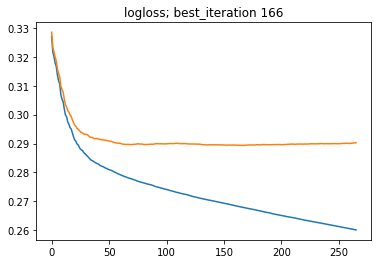

In [22]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

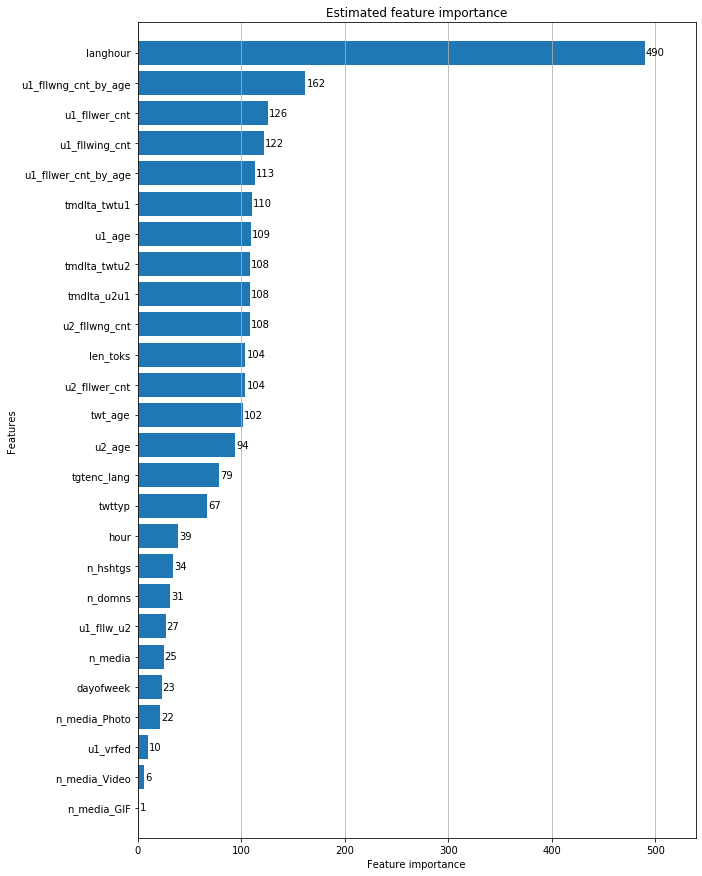

In [23]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [24]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
25,langhour,490
24,u1_fllwng_cnt_by_age,162
1,u1_fllwer_cnt,126
2,u1_fllwing_cnt,122
23,u1_fllwer_cnt_by_age,113
18,tmdlta_twtu1,110
21,u1_age,109
17,tmdlta_u2u1,108
5,u2_fllwng_cnt,108
19,tmdlta_twtu2,108


# eval

In [25]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 5.85 s, sys: 4.34 s, total: 10.2 s
Wall time: 949 ms


In [26]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 932 ms, sys: 1.65 s, total: 2.58 s
Wall time: 646 ms


In [27]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.3859
auc_vl:  0.2854
auc_val: 0.0904

rce_tr:  19.8420
rce_vl:  13.8880
rce_val: 9.9579


In [28]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.0904-9.9579


# save results

In [29]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [30]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [31]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 42.2 ms, sys: 88.2 ms, total: 130 ms
Wall time: 8.58 ms


In [32]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-06 15:28:25 start
2020-04-06 15:28:25 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-06 15:28:25 freq of tags
2020-04-06 15:28:25 done
CPU times: user 284 ms, sys: 1.24 s, total: 1.52 s
Wall time: 161 ms


In [33]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [34]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 10.6 ms, sys: 13.1 ms, total: 23.6 ms
Wall time: 16.1 ms


In [35]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)